##### Modules

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

import numpy as np
from data_handler import DataHandler
from droplet_model import DropletModel, ReparameterisedDropletModel, DropletModelUnknownInitialConditions
from parameter_fitting import ParameterFitting
from plots import Plots
import matplotlib.pyplot as plt
import pints
import pints.plot
from scipy.integrate import odeint
from numba import njit
import seaborn as sns
from cycler import cycle

##### Log-likelihoods

In [ ]:
class AdditiveNormalSigmaMLEIndicatorLogLikelihood(pints.ProblemLogLikelihood):

    def __init__(self, problem, zero_tol=0.0):
        """
        Parameters
        ----------
        problem : pints.Problem
            the PINTS problem that provides .n_outputs(), .n_times(), .evaluate(x) etc.
        zero_tol : float
            any sse <= zero_tol is treated as "zero error" and that output is ignored.
            Use 0.0 to ignore only exact zeros or something like 1e-16 for numerical safety.
        """
        super(AdditiveNormalSigmaMLEIndicatorLogLikelihood, self).__init__(problem)
        self._no = problem.n_outputs()
        self._np = problem.n_parameters()
        self._nt = problem.n_times()
        self._zero_tol = float(zero_tol)



    def __call__(self, x, prior=None):
        # evaluate residuals
        error = self._values - self._problem.evaluate(x)
        sse = np.sum(error**2, axis=0) / float(self._nt)  # length = no

        # choose eps relative to data scale
        data_var = np.var(self._values) if self._values.size else 1.0
        eps = max(self._zero_tol, 1e-12, 1e-8 * data_var)
        sse_safe = np.maximum(sse, eps)

        k = self._no
        log_term = -0.5 * np.sum(np.log(sse_safe))
        offset = -0.5 * k * self._nt * (np.log(2.0 * np.pi) + 1.0)

        log_like = offset + log_term

        # optional inverse-gamma prior on sigma^2 (sse_safe is sigma^2 * n_t)
        if prior is not None:
            # prior should be dict e.g. {'type':'inv_gamma','a':1.0,'b':1e-6}
            if prior.get('type') == 'inv_gamma':
                a = float(prior.get('a', 1.0))
                b = float(prior.get('b', 1e-6))
                # sigma2 = sse_safe  (we're using SSE/n_t already)
                # log prior (sum over outputs):  - (a+1)*log(sigma2) - b/sigma2  (ignore const)
                log_prior = - (a + 1.0) * np.sum(np.log(sse_safe)) - b * np.sum(1.0 / sse_safe)
                log_like += log_prior

        return float(log_like)
    

class TwoParamHeteroLogLikelihood(pints.LogPDF):
    def __init__(self, problem, n_theta, eps=1e-12):
        """
        problem : pints.MultiOutputProblem
        n_theta : number of mechanistic parameters (theta)
        """
        self._problem = problem
        self._n_theta = n_theta
        self._eps = eps  # small floor to keep things numeric

    def n_parameters(self):
        # theta (n_theta) + alpha + beta
        return self._n_theta + 2

    def __call__(self, x):
        """
        x = [ theta_0, ..., theta_{n_theta-1}, log_alpha, beta ]
        We parameterise alpha via log_alpha so alpha>0 automatically.
        """
        theta = x[:self._n_theta]
        log_alpha = x[self._n_theta]
        beta = x[self._n_theta + 1]

        alpha = np.exp(log_alpha)          # enforce positivity
        sim = np.asarray(self._problem.evaluate(theta))   # shape: (n_times, n_outputs)
        y   = np.asarray(self._problem.values())          # same shape

        # choose a per-output scale: e.g. time-mean of the simulated output
        # result is vector of length n_outputs
        phi_mean = sim.mean(axis=0)
        sigma_per_output = alpha * (phi_mean + self._eps)**beta
        # Broadcast to full shape (n_times, n_outputs)
        sigma = np.tile(sigma_per_output[np.newaxis, :], (sim.shape[0], 1))

        # compute Gaussian log-likelihood (sum over times and outputs)
        resid = (y - sim)
        ll = -0.5 * np.sum((resid / sigma)**2 + np.log(2*np.pi*sigma**2))

        return float(ll)

### Synthetic data

##### Generate synthetic data

In [33]:
def generate_synthetic_data(
    model,
    model_params,
    data_times,
    sigma_values,
    noise_factor=None,
    noise_model="additive normal",
    rng=None
):
    
    model_sol = model.simulate(model_params, data_times)
    N = model.n_outputs()
    T = len(data_times)


    if sigma_values is None:

        sigma_values = noise_factor * np.std(model_sol, axis=0)

    if rng is None:
        rng = np.random.default_rng()

    eps = rng.normal(loc=0.0, scale=sigma_values.reshape(1, N), size=(T, N))

    if noise_model == "additive normal":

        synthetic_prediction = model_sol + eps
        
    elif noise_model == "multiplicative normal":

        synthetic_prediction = model_sol * (1 + eps)

    elif noise_model == "lognormal":

        synthetic_prediction = model_sol * np.exp(eps)

    return sigma_values, synthetic_prediction

In [69]:
data_handler = DataHandler()
ntc_ics = data_handler.get_gene_average_array(pool_id=1, gene_id="NTC (avg)", max_bin_number=51)[0]

synthetic_initial_conditions = ntc_ics

synthetic_model = DropletModel(initial_conditions=synthetic_initial_conditions)
data_times = [4,6,8,11,14]


synthetic_model_params = np.asarray([3e3, 3e-5, 2e-1])


model_times = np.linspace(4,14,200)
synthetic_true_model_sol = synthetic_model.simulate(params=synthetic_model_params, times=model_times)

synthetic_sigma_values, synthetic_data = generate_synthetic_data(
    model=synthetic_model,
    model_params=synthetic_model_params,
    data_times=data_times,
    sigma_values=None,
    noise_factor=0.1
)
synthetic_problem = pints.MultiOutputProblem(synthetic_model, data_times, synthetic_data)

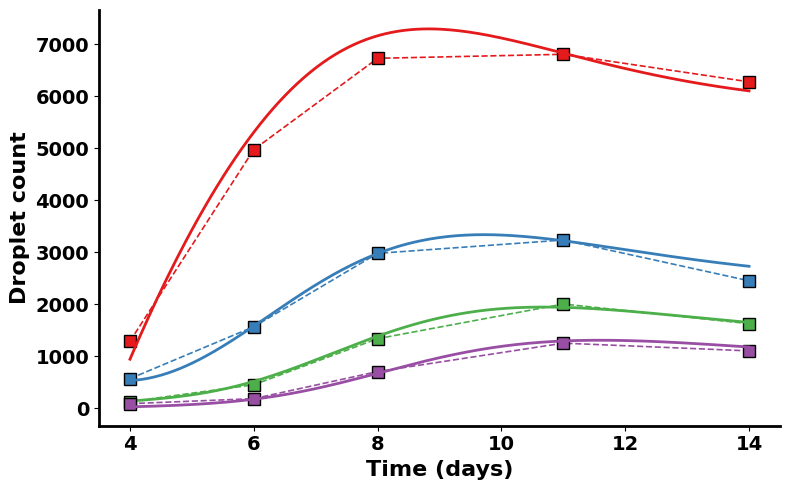

In [70]:
plotter = Plots()
plotter.plot_data_and_model_timecourse(
    model_sol=synthetic_true_model_sol,
    data_array=synthetic_data
)

##### Optimisation

In [78]:
def weighted_sum_score(problem, sigma_values):

    sigma_weights = [1/sigma**2 for sigma in sigma_values]

    return pints.SumOfSquaresError(problem, weights=sigma_values)

In [79]:


opt_lower_bounds = np.asarray([1e1, 1e-10, 1e-2])
opt_upper_bounds = np.asarray([1e4, 1e-3, 1e0])

lower_sigma = 0.5 * synthetic_sigma_values
upper_sigma = 2 * synthetic_sigma_values + 1e-2

param_mles = {}

opt_bounds = pints.RectangularBoundaries(opt_lower_bounds, opt_upper_bounds)
log_prior = pints.UniformLogPrior(opt_bounds)

# log_likelihood = AdditiveNormalSigmaMLEIndicatorLogLikelihood(problem=synthetic_problem)

# log_likelihood = AdditiveNormalSigmaMLEIndicatorLogLikelihood(synthetic_problem, zero_tol=1)

log_likelihood = weighted_sum_score(synthetic_problem, synthetic_sigma_values)

log_prior_sample = log_prior.sample(1)[0]

# opt_initial_position = [list(log_prior_sample[:51])] + list(log_prior_sample[51:])

opt_initial_position = log_prior_sample

# transformation = pints.LogTransformation(n_parameters=3+51)

transformation=None

opt = pints.OptimisationController(
    log_likelihood, 
    opt_initial_position, 
    boundaries=opt_bounds, 
    method=pints.XNES,
    transformation=transformation
)

opt.set_log_to_screen(True)
opt_params, opt_max_likelihood = opt.run()

print('Estimated parameters:')
print(opt_params)

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     6      1.82e+09  1.82e+09   0:00.0
1     12     1.22e+09  1.22e+09   0:00.0
2     18     1.22e+09  3.82e+09   0:00.1
3     24     1.22e+09  2.14e+09   0:00.1
20    124    1.22e+09  2.16e+09   0:00.4
40    264    2.84e+08  2.84e+08   0:00.8
60    404    1.27e+08  1.27e+08   0:01.1
80    544    6.52e+07  6.65e+07   0:01.4
100   684    6.15e+07  6.15e+07   0:01.7
120   824    6.14e+07  6.14e+07   0:02.0
140   964    6.14e+07  6.14e+07   0:02.3
160   1104   6.14e+07  6.14e+07   0:02.6
180   1244   6.14e+07  6.14e+07   0:02.9
200   1384   6.14e+07  6.14e+07   0:03.2
220   1524   6.14e+07  6.14e+07   0:03.5
240   1664   6.14e+07  6.14e+07   0:03.8
260   1804   6.14e+07  6.14e+07   0:04.1
280   1944   6.14e+07  6.14e+07   0:04.4
300   2084   6.14e+07  6.14e+07   0:04.7
320   2224   6.14e+07  6.14e+07   0:05.0
340   2364   6.

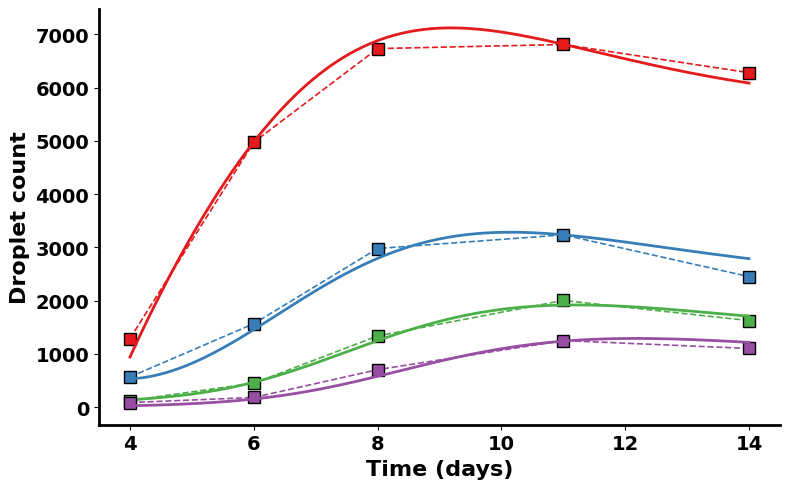

In [80]:
estimated_model_sol = synthetic_model.simulate(params=opt_params, times=model_times)
plotter.plot_data_and_model_timecourse(
    model_sol=estimated_model_sol,
    data_array=synthetic_data
)

### Experimental data

##### Get data

In [60]:
data_handler = DataHandler(dataset="preliminary dataset", base_path="../")

pool_id = 1

all_gene_names = data_handler.get_pool_gene_ids(pool_id=1)

print(all_gene_names)

['NTC (avg)', 'NTC1', 'NTC2', 'NTC3', 'NTC4', 'NTC5', 'NTC6', 'NTC7', 'NTC8', 'NTC9', 'NTC10', 'NTC11', 'NTC12', 'NTC13', 'NTC14', 'NTC15', 'PPARG2', 'CEBPA', 'IRS-1', 'FST', 'MAP3K1', 'GRB14', 'TCF7L2', 'HDAC1', 'RETN', 'IFI16', 'ZNF423', 'LPIN1', 'RB1', 'HSD11B1', 'BAMBI', 'PEPD', 'PDGFC', 'RSPO3', 'SIRT1', 'SERPINF1', 'PTEN', 'DDR2', 'PAPOLA', 'POLA1', 'XBP1', 'ZNF207', 'NA']


In [61]:
gene_id = "NTC (avg)"

data_array = data_handler.get_gene_average_array(
    pool_id=pool_id, 
    gene_id=gene_id, 
    max_bin_number=51)

data_times = data_handler.data_times

##### Optimisation

In [62]:
def get_sigma_MLEs(
    model, 
    data, 
    mle_params, 
    data_times, 
    noise_model="additive normal"
):

    opt_model_sol = model.simulate(mle_params, data_times)
    residuals = opt_model_sol - data

    n_t = len(data_times)

    if noise_model == "additive normal":

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(residuals**2, axis=0))

    elif noise_model == "multiplicative normal":

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(residuals**2 / opt_model_sol, axis=0))

    elif noise_model == "lognormal":

        log_residuals = np.log(data) - np.log(opt_model_sol)

        log_residuals = np.nan_to_num(log_residuals, nan=0)

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(log_residuals**2, axis=0))

    return sigma_MLEs

In [67]:
initial_conditions = data_array[0]
model = DropletModel(initial_conditions=initial_conditions)
problem = pints.MultiOutputProblem(model, data_times, data_array)

# sigma_mles = get_sigma_MLEs(
#     model=model,
#     data=data_array,
#     mle_params=,
#     data_times=data_times
# )

opt_lower_bounds = [1e1, 1e-10, 1e-2] #+ [0]*51
opt_upper_bounds = [1e4, 1e-4, 1e0] #+ [1000]*51

param_mles = {}

opt_bounds = pints.RectangularBoundaries(opt_lower_bounds, opt_upper_bounds)
log_prior = pints.UniformLogPrior(opt_bounds)

log_likelihood = AdditiveNormalSigmaMLEIndicatorLogLikelihood(problem=problem, zero_tol=1)

opt_initial_position = log_prior.sample(1)

transformation = pints.LogTransformation(n_parameters=3)

opt = pints.OptimisationController(
    log_likelihood, 
    opt_initial_position, 
    boundaries=opt_bounds, 
    method=pints.CMAES,
    transformation=transformation
)

opt.set_log_to_screen(True)
opt_params, opt_max_likelihood = opt.run()

print('Estimated parameters:')
print(opt_params)

param_mles["b"] = opt_params[0]
param_mles["f"] = opt_params[1]
param_mles["g"] = opt_params[2]

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     7     -456.2955 -456.2955   0:00.0
1     14    -439.5873 -439.5873   0:00.0
2     21    -421.4806 -421.4806   0:00.1
3     28    -421.4806 -425.7798   0:00.1
20    147   -421.3502 -423.8666   0:00.3
40    287   -419.3888 -419.4868   0:00.5
60    427   -418.6403 -418.6403   0:00.8
80    567   -418.2878 -418.4071   0:01.0
100   707   -418.2262 -418.2263   0:01.2
120   847   -418.2255 -418.2255   0:01.5
140   987   -418.2255 -418.2255   0:01.7
160   1127  -418.2255 -418.2255   0:01.9
180   1267  -418.2255 -418.2255   0:02.1
200   1407  -418.2255 -418.2255   0:02.4
220   1547  -418.2255 -418.2255   0:02.6
240   1687  -418.2255 -418.2255   0:02.8
260   1827  -418.2255 -418.2255   0:03.1
280   1967  -418.2255 -418.2255   0:03.3
300   2107  -418.2255 -418.2255   0:03.5
320   2247  -418.2255 -418.2255   0:03.7
340   2387 

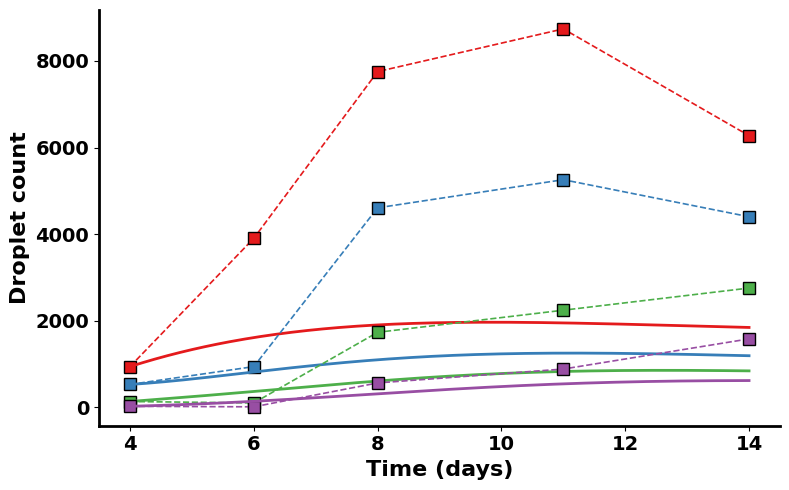

In [68]:
model_times = np.linspace(4,14,200)
model_sol = model.simulate(opt_params, model_times)

plotter = Plots()

plotter.plot_data_and_model_timecourse(
    model_sol=model_sol,
    data_array=data_array
)




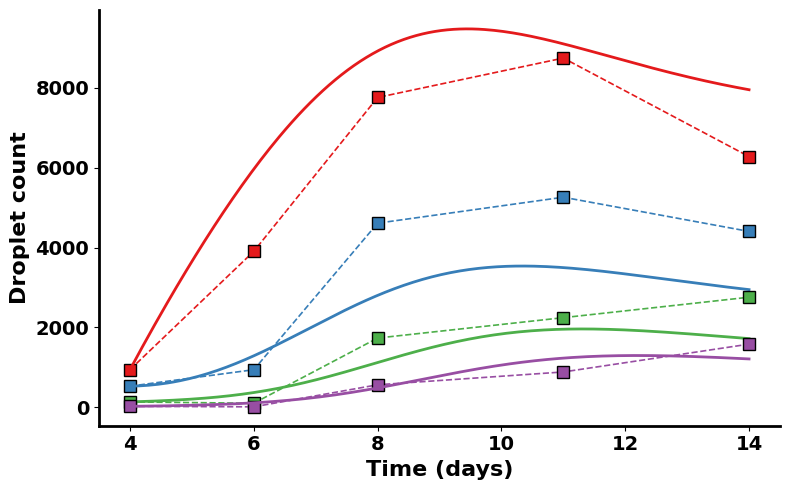

In [34]:
model_times = np.linspace(4,14,200)
model_sol = model.simulate([3e3, 3e-5, 1e-1], model_times)

plotter = Plots()

plotter.plot_data_and_model_timecourse(
    model_sol=model_sol,
    data_array=data_array
)

In [39]:
print(log_likelihood([1.89974821e+02, 9.79078310e-05, 2.76293520e-01]))

print(log_likelihood([3e3, 3e-5, 1e-1]))

print(log_likelihood([0,0,0]))

-354.62773612885996
-430.90207117446164
-399.37911441644377


In [81]:
print(data_array)

[[9.43539583e+02 5.30856250e+02 1.37283333e+02 2.68125000e+01
  5.15625000e+00 1.05000000e+00 2.79166667e-01 9.37500000e-02
  2.08333333e-02 2.08333333e-03 2.08333333e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.90521250e+03 9.42906250e+02 1.04239583e+02 1.46708333e+01
  4.07083333e+00 1.41041667e+00 5.37500000e-01 2.04166667e-01
  8.75000000e-02 4.37500000e-02 2.50000000e-02 1.04166667e-02
  1.04166667e-02 4.166